<a href="https://colab.research.google.com/github/adong-hood/cs200/blob/main/ch_8_1_8_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Recap: Web Scraping 1

In [ ]:
import pandas as pd
import altair as alt
import requests
from bs4 import BeautifulSoup

In [ ]:
address = 'http://pluto.hood.edu/~dong/factbook-2017/fields/2091.html#118'
res = requests.get(address)
my_page = res.text
my_page = BeautifulSoup(my_page)

In [ ]:
dict_infant_mortality_rate = {}
cols = my_page.select("#fieldListing tr")
for col in cols:
    if len(str(col).split('/geos/')) > 1:
        code = str(col).split('/geos/')[1][:2]
    cells = col.select('td')
    if len(cells) > 0:
        total_rate = cells[1].text.strip()
        dict_infant_mortality_rate[code] = total_rate

dict_infant_mortality_rate

In [ ]:
ser_infant_mortality_rate = pd.Series(dict_infant_mortality_rate)
df_infant_mortality_rate = pd.DataFrame(ser_infant_mortality_rate, columns = ["Infant mortality rate"])
df_infant_mortality_rate.head()

Infant mortality rate
af  total: 110.6 deaths/1,000 live births\nmale: 1...
al  total: 11.9 deaths/1,000 live births\nmale: 13...
ag  total: 19.6 deaths/1,000 live births\nmale: 21...
aq  total: 11.3 deaths/1,000 live births\nmale: 13...
an  total: 3.6 deaths/1,000 live births\nmale: 3.6...

In [ ]:
test_string =  'total: 10.7 deaths/1,000 live births\nmale: 14 deaths/1,000 live births\nfemale: 7.4 deaths/1,000 live births (2017 est.)'

def im_clean(text):
    try:
        split_text = text.split(':')
        death_number = split_text[1].strip().split('deaths')[0].strip()
        infant_mortality = float(death_number)
        return (infant_mortality)
    except:
        return(float('NaN'))

im_clean(test_string)

10.7

In [ ]:
df_infant_mortality_rate['cleaned_rate'] = df_infant_mortality_rate['Infant mortality rate'].map(im_clean)
df_infant_mortality_rate.head()

Infant mortality rate  cleaned_rate
af  total: 110.6 deaths/1,000 live births\nmale: 1...         110.6
al  total: 11.9 deaths/1,000 live births\nmale: 13...          11.9
ag  total: 19.6 deaths/1,000 live births\nmale: 21...          19.6
aq  total: 11.3 deaths/1,000 live births\nmale: 13...          11.3
an  total: 3.6 deaths/1,000 live births\nmale: 3.6...           3.6

In [ ]:
df_infant_mortality_rate['cleaned_rate'].mean()

22.12964601769914

## Chapter 8 UN Speech

This analysis follows sections 8.2 from chapter 8. **Please refer to the book and the notebook concurrently**. It requires the 'un-general-debates.csv' and 'country_codes.csv' datasets.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import altair as alt


In [ ]:
undf = pd.read_csv('http://pluto.hood.edu/~dong/datasets/un-general-debates.csv')
len(undf) # total number of speeches.

7507

In [ ]:
undf.head(3) # check out the information.

session  year country                                               text
0       44  1989     MDV  ﻿It is indeed a pleasure for me and the member...
1       44  1989     FIN  ﻿\nMay I begin by congratulating you. Sir, on ...
2       44  1989     NER  ﻿\nMr. President, it is a particular pleasure ...

In [ ]:
# sort speeches by year.
undf.sort_values('year', ascending = False).head(3)

session  year country                                               text
5543       70  2015     KNA  It is indeed an honour for me to address this ...
5524       70  2015     KOR  I would first like to congratulate the United ...
5522       70  2015     ARE  It is my pleasure to congratulate Mr. Mogens L...

In [ ]:
# Sets column width to as wide as it takes.
pd.set_option('display.max_colwidth', None)
# prints a speech by USA from 1970 with wide columns.
print(undf[(undf.year == 1970) & (undf.country == 'USA')].text)
# Sets width back to normal...
pd.set_option('display.max_colwidth', 50)

## Q1. How many speeches were given each year?

The code below first groups undf by year. 'as_index = False' means we'll have years as a column rather than as row labels. \[\'text\'\] subsets the undf to just the text column, and .count() returns the number of texts. So there were 70 speeches in 1970.

In [ ]:
#
by_year = undf.groupby('year', as_index=False)['text'].count()
by_year.head()

year  text
0  1970    70
1  1971   116
2  1972   125
3  1973   120
4  1974   129

## Q2. Make a bar graph of the number of speeches each year.

In [ ]:
#

This creates our first graph of this section - showing how many speeches there have been each year.

Merge with country_codes so that we can use country names instead of 3-letter country code.

Read the country_codes.csv file as a dataframe named as c_codes.

In [ ]:
c_codes = pd.read_csv('http://pluto.hood.edu/~dong/datasets/country_codes.csv', encoding = "ISO-8859-1")
c_codes.head(3)

country code_2 code_3  country_code     iso_3166_2 continent  \
0    Afghanistan     AF    AFG             4  ISO 3166-2:AF      Asia   
1  Åland Islands     AX    ALA           248  ISO 3166-2:AX    Europe   
2        Albania     AL    ALB             8  ISO 3166-2:AL    Europe   

        sub_region  region_code  sub_region_code  
0    Southern Asia        142.0             34.0  
1  Northern Europe        150.0            154.0  
2  Southern Europe        150.0             39.0

Create a new dataframe named as c_codes_short, which contains only the code_3, country, continent, sub_region columns from undf.

In [ ]:
c_codes_short = c_codes[['code_3', 'country', 'continent', 'sub_region']]

Merge the orginal undf dataframe with c_codes_short and save the result as a new dataframe undfe. Use the default inner-join merge. First rename the 'country' column in **undf** to 'code_3' so that these two data frames can merge using code_3.

In [ ]:
undf = undf.rename({'country': 'code_3'}, axis = 1)
undfm = undf.merge(c_codes_short)
print(len(undfm))
undfm.head(3)


7406


session  year code_3                                               text  \
0       44  1989    MDV  ﻿It is indeed a pleasure for me and the member...   
1       68  2013    MDV  I wish to begin by \nextending my heartfelt co...   
2       63  2008    MDV  I am delivering this \nstatement on behalf of ...   

    country continent     sub_region  
0  Maldives      Asia  Southern Asia  
1  Maldives      Asia  Southern Asia  
2  Maldives      Asia  Southern Asia

## Q3. How many speeches were given by each country?

In [ ]:
#

This creates a new grouping of the data - this time by country. Looking at the top of the data we can see that AFG (Afghanistan) has given 45 speeched at the UN General Debate.  

## Q4. Given data from Q3, displays the number of speeches distribution.

This histogram displays the number of speeches for each country. The data is left skewed - meaning most of the countries have spoken between 40 and 50 times, while a smaller number of the countries have spoken fewer times. As these speeches only go back to 1970 and go up to 2015, 45 is the upper limit on the number of times a country could have spoken.

In [ ]:
#

## Q5. Which country has the most number of speeches? Which one has the least?

.idxmax() and .idxmin() return the countries that have given the most and fewest number of speeches.  

In [ ]:
#

In [ ]:
#


topics (below) is a list of key words that have shown up in UN speeches. We'd like to see how these topics have showed up over time in the speeches.

In [ ]:
topics = [' nuclear', ' weapons', ' nuclear weapons', ' chemical weapons',
          ' biological weapons', ' mass destruction', ' peace', ' war',
          ' nuclear war', ' civil war', ' terror', ' genocide', ' holocaust',
          ' water', ' famine', ' disease', ' hiv', ' aids', ' malaria',
          ' cancer', ' poverty', ' human rights', ' abortion', ' refugee',
          ' immigration', ' equality', ' democracy', ' freedom',
          ' sovereignty', ' dictator', ' totalitarian', ' vote', ' energy',
          ' oil',  ' coal',  ' income', ' economy', ' growth', ' inflation',
          ' interest rate', ' security', ' cyber', ' trade', ' inequality',
          ' pollution', ' global warming', ' hunger', ' education',
          ' health', ' sanitation', ' infrastructure', ' virus',
          ' regulation', ' food', ' nutrition', ' transportation',
          ' violence', ' agriculture', ' diplomatic', ' drugs', ' obesity',
          ' islam', ' housing', ' sustainable', 'nuclear energy']

In [ ]:
undfm.head(3)

session  year code_3  ...   country continent     sub_region
0       44  1989    MDV  ...  Maldives      Asia  Southern Asia
1       68  2013    MDV  ...  Maldives      Asia  Southern Asia
2       63  2008    MDV  ...  Maldives      Asia  Southern Asia

[3 rows x 7 columns]

We'd like to lump all of the speeches for each year together, so we can go through and count up all of the times a key word showed up that year. year_summ has years in the first column, and the text of all speeches given that year in the second column.

In [ ]:
year_summ = undfm.groupby('year', as_index = False)['text'].sum()
#year_summ.head(3)

In [ ]:
year_summ.head(3)


year                                               text
0  1970  37.\t On behalf of my country, may I congratul...
1  1971  1.\t  It is a pleasure for me to extend to you...
2  1972  Mr. President, it gives me great pleasure to e...

In [ ]:
len(year_summ.iloc[0,1]) # the lenght of all speeches given in 1970.

1679270

Only select one year to create the word cloud.

In [ ]:
text_1970 = year_summ[year_summ.year == 1970]
len(text_1970.iloc[0,1])

1679270

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
wordcloud_1970 = WordCloud(background_color ='white', min_font_size = 10).generate(text_1970.iloc[0,1])


(-0.5, 399.5, 199.5, -0.5)

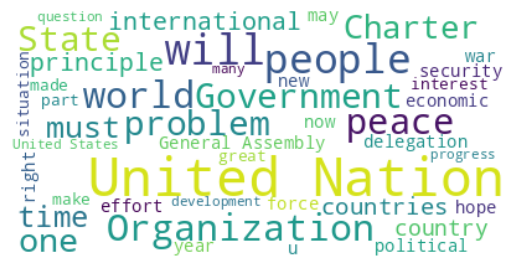

In [ ]:
plt.imshow(wordcloud_1970, interpolation='bilinear')
plt.axis("off")

## Q6. Generate a word cloud for the speeches from 2015.

In [ ]:
#

## Q7. How topics of 'global warming' and 'climate change' in UN speeches have changed over the years?

Now we will add some columns to out dataframe by counting the number of times 'global warming' and 'climate change' occur in each year's corpus.

In [ ]:
year_summ['gw'] = year_summ.text.str.count('global warming')
year_summ['cc'] = year_summ.text.str.count('climate change')
#year_summ.head(10)
year_summ.tail(10)

In [ ]:
alt.Chart(year_summ[['year', 'gw', 'cc']]).mark_line().encode(x = 'year', y= 'gw')

.melt is a useful command to use with altair. It lets you combine two columns (gw and cc) into an indicator variable (in this case a color for gw or cc) and a value variable (how often each term has showed up.) [More about using melt here.](https://altair-viz.github.io/user_guide/data.html?highlight=melt#converting-between-long-form-and-wide-form-pandas)


In [ ]:
alt.Chart(year_summ[['year', 'gw', 'cc']].melt(
    id_vars='year', value_vars=['cc','gw'])).mark_line().encode(
    x='year:O',y='value', color='variable')

## Q8. How topics of 'internet' and 'nationalist' in UN speeches have changed over the years?
Refer to "How topics of 'global warming' and 'climate change' in UN speeches have changed over the years?" for solution/graph. Use one graph to show trends for both topics, just like the graph for 'global warming' and 'climate change.'

In [ ]:
#

Now we'll look at the length of each speech.

In [ ]:
undfm['text_len'] = undfm.text.map(lambda x : len(x.split())) # add a new column for speech length.

In [ ]:
undfm.head(3)

## Q9.   Find out the average speech length for each country.

In [ ]:
#

That gives the average speech length for each country. Now we'll use altair to make a histogram of those lengths.

In [ ]:
#

So most of the speeches are between 2500 and 3500 words in length. For comparison, the Gettysburg Address had 272 words, and Harry Potter and the Sorcerer's Stone had about 77 thousand words.

## Q10. Judging from the averages, what countries gave the shortest and longest speeches?

In [ ]:
#

In [ ]:
#

So Russia has given the longest speeches, and Brunei has given the shortest, on average.